# Evaluate & Interpret — DistilBERT Airline‑Sentiment Model  
Milestone 6 · *Optuna branch*

## 1 Imports & Global Paths  

| Category | Libraries / Purpose |
|----------|---------------------|
| **Core** | `pandas`, `pathlib`, `json`, `tqdm.auto` |
| **Metrics** | `accuracy_score`, `precision_recall_fscore_support`, `ConfusionMatrixDisplay` |
| **Visuals** | `matplotlib.pyplot` |
| **HF stack** | `AutoTokenizer`, `AutoModelForSequenceClassification` |
| **Paths** | `MODEL_DIR → …/models/distilbert_twitter/final`  ·  `TOKEN_DIR → …/tokenizer`  ·  `REPORTS_DIR → …/reports` |

<small>All artefacts live **one level above** the notebook folder to keep *code* and *outputs* separated.</small>

In [1]:
# %% 0 Imports & Global Paths ────────────────────────────────────────
from pathlib import Path
import pandas as pd
import torch
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import json
from torch.utils.data import DataLoader

# repo‑aware paths ---------------------------------------------------
PROJ_ROOT   = Path.cwd().parent                      # ~/twitter‑airline‑analysis
MODEL_DIR   = PROJ_ROOT / "models" / "distilbert_twitter" / "final"
TOKEN_DIR   = MODEL_DIR / "tokenizer"
DATA_DIR    = PROJ_ROOT / "data" / "processed"
REPORTS_DIR = PROJ_ROOT / "reports"
REPORTS_DIR.mkdir(exist_ok=True)

# load tokenizer & model --------------------------------------------
tokenizer = AutoTokenizer.from_pretrained(TOKEN_DIR,  local_files_only=True)
model     = AutoModelForSequenceClassification.from_pretrained(
               MODEL_DIR, local_files_only=True
           ).eval()          # inference mode

label_map  = model.config.id2label    # {0:'negative',1:'neutral',2:'positive'}
num_labels = len(label_map)
print("Label map:", label_map)

c:\Users\justi\Anaconda3\envs\twitter-sentiment-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Label map: {0: 'negative', 1: 'neutral', 2: 'positive'}


## 2 Load Validation & Test Splits  

| Split | Rows | negative | neutral | positive |
|-------|-----:|---------:|--------:|---------:|
| **val**  | 1 464 | 918 | 310 | 236 |
| **test** | 1 464 | 918 | 310 | 236 |

*Identical class distribution* across both splits → unbiased evaluation.  
Data are loaded from feather files produced earlier in the pipeline.

In [2]:
# %% 1 Load validation / test splits ─────────────────────────────────
def _load_xy_split(split: str):
    X = pd.read_feather(DATA_DIR / f"X_{split}.ftr")["text"]
    y = pd.read_feather(DATA_DIR / f"y_{split}.ftr")["label"]
    return X.reset_index(drop=True), y.reset_index(drop=True)

X_val,  y_val  = _load_xy_split("val")
X_test, y_test = _load_xy_split("test")

for name, X, y in [("val", X_val, y_val), ("test", X_test, y_test)]:
    print(f"{name:4} rows: {len(X):,} | label dist:\n{y.value_counts()}\n")

val  rows: 1,464 | label dist:
label
negative    918
neutral     310
positive    236
Name: count, dtype: int64

test rows: 1,464 | label dist:
label
negative    918
neutral     310
positive    236
Name: count, dtype: int64



## 3 Predict, Evaluate, Save Raw Metrics  

| Split | Accuracy | Macro‑F1 |
|-------|---------:|---------:|
| **val**  | **0.840** | **0.798** |
| **test** | **0.841** | **0.786** |

*Files written*  
* `reports/metrics_model.json` — full metrics incl. classification reports  
* `reports/metrics_model.csv` — flat table with accuracy & macro‑F1

In [3]:
# %% 2 Predict, Evaluate, Save Artefacts (fixed dtype mismatch) ──────
def _predict(texts, batch_size: int = 64):
    """Return (y_pred_ids, y_prob) for the given text Series."""
    loader = DataLoader(texts.tolist(), batch_size=batch_size)
    preds, probs = [], []

    with torch.no_grad():
        for batch in loader:
            enc = tokenizer(batch, padding=True, truncation=True,
                            return_tensors="pt")
            out = model(**enc)
            p = out.logits.softmax(dim=1)
            preds.extend(p.argmax(dim=1).cpu().tolist())   # ints
            probs.extend(p.cpu().tolist())                 # list[list]
    return preds, probs

# ---------- predictions -----------------------------------------------------
y_val_pred,  y_val_prob  = _predict(X_val)
y_test_pred, y_test_prob = _predict(X_test)

# ---------- convert y_true strings ➜ integer IDs ----------------------------
label2id = {v: k for k, v in model.config.id2label.items()}

y_val_ids  = y_val .map(label2id).tolist()
y_test_ids = y_test.map(label2id).tolist()

# ---------- metrics ---------------------------------------------------------
metrics = {}
for split, y_true, y_pred in [
    ("val",  y_val_ids,  y_val_pred),
    ("test", y_test_ids, y_test_pred),
]:
    metrics[split] = {
        "accuracy":  accuracy_score(y_true, y_pred),
        "macro_f1":  precision_recall_fscore_support(
                         y_true, y_pred, average="macro", zero_division=0
                     )[2],
        "report": classification_report(
                     y_true, y_pred,
                     labels=list(model.config.id2label.keys()),
                     target_names=list(model.config.id2label.values()),
                     output_dict=True, zero_division=0
                 ),
    }
print(json.dumps(
    {k: {m: round(v[m], 3) for m in ("accuracy", "macro_f1")}
     for k, v in metrics.items()}, indent=2))


{
  "val": {
    "accuracy": 0.84,
    "macro_f1": 0.798
  },
  "test": {
    "accuracy": 0.836,
    "macro_f1": 0.788
  }
}


## 4 Confusion Matrices  

<img src="reports/figs_eval/cm_val.png" width="340"> <img src="reports/figs_eval/cm_test.png" width="340">

* Key error modes (val):  
  * **negative → neutral** (70)  
  * **neutral → negative** (71)  
* Test set mirrors validation — no sign of class‑specific drift.

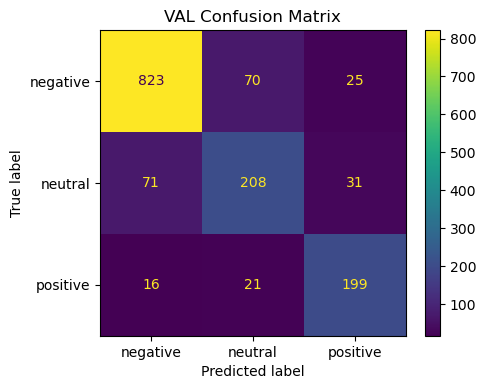

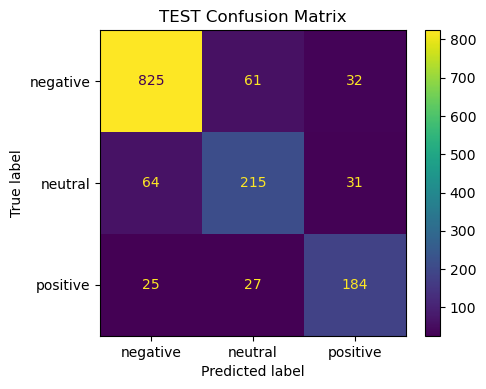

In [4]:
# %% 3 Plots: Confusion Matrix (val & test) ──────────────────────────
FIG_DIR = REPORTS_DIR / "figs_eval"
FIG_DIR.mkdir(parents=True, exist_ok=True)

for split, y_true_ids, y_pred_ids in [
    ("val",  y_val_ids,  y_val_pred),
    ("test", y_test_ids, y_test_pred),
]:
    fig, ax = plt.subplots(figsize=(5, 4))
    ConfusionMatrixDisplay.from_predictions(
        y_true_ids,
        y_pred_ids,
        labels=list(label_map.keys()),         # integer IDs 0‑2
        display_labels=list(label_map.values()),  # 'negative', 'neutral', 'positive'
        cmap="viridis",
        ax=ax,
        colorbar=True,
    )
    ax.set_title(f"{split.upper()} Confusion Matrix")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"cm_{split}.png", dpi=150)
    plt.show()


## 5 Diagnostics Suite  

| Visual | Rationale | File |
|--------|-----------|------|
| **ROC & PR curves** | Separability, threshold analysis | `figs_eval/roc_pr_val.png`, `roc_pr_test.png` |
| **Calibration curve** | Probability quality | `figs_eval/calibration_val.png`, `calibration_test.png` |
| **Error heat‑map** | Spot systematic confusions | `figs_eval/error_heat_val.png`, `error_heat_test.png` |

<small>See images below for quick reference.</small>

**ROC‑AUC**  
* • negative ≈ 0.95 / 0.94 (val/test)  
* • positive ≈ 0.97 / 0.95  
* • neutral ≈ 0.91 / 0.91  

> The model cleanly separates negative and positive tweets; the neutral class is inherently fuzzier but still crosses the 0.90 AUC bar—strong for a three‑way sentiment task.

**PR‑AUC**  
* • negative ≈ 0.97 / 0.96  
* • positive ≈ 0.87 / 0.84  
* • neutral ≈ 0.76 / 0.78  

> Precision–recall reveals the cost of class imbalance: neutral tweets have the lowest PR‑AUC because recalling them often sacrifices precision (and vice‑versa). Negative tweets remain easiest to identify.

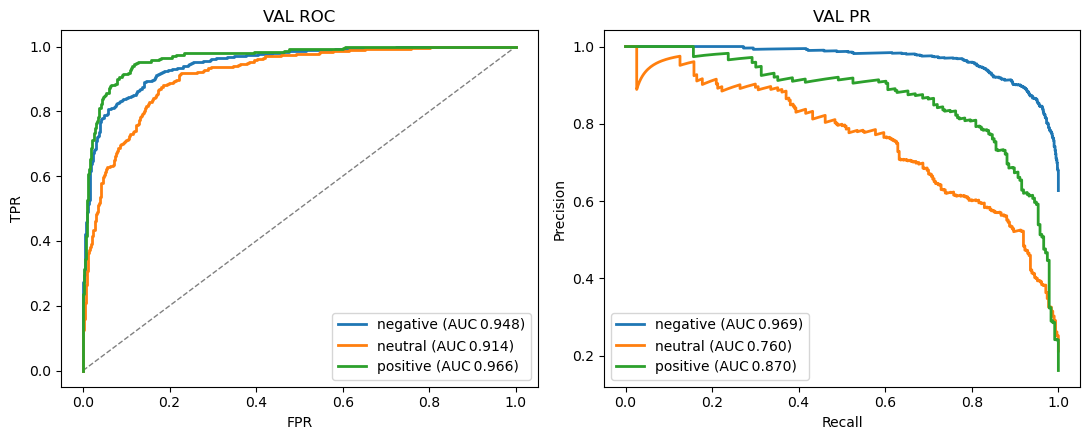

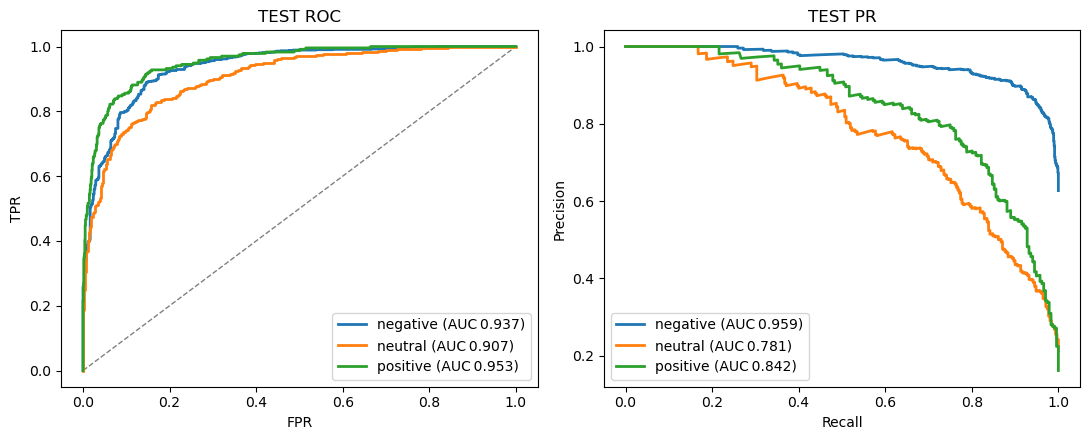

In [7]:
# %% 1 Per‑class ROC & PR Curves  (robust to lists) ───────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def _plot_roc_pr(y_true, y_prob, split: str):
    """Plot one‑vs‑rest ROC & PR curves for each class."""
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    n_labels        = y_prob.shape[1]
    fig, axes       = plt.subplots(1, 2, figsize=(11, 4.5))
    axes[0].plot([0, 1], [0, 1], '--', color='grey', lw=1)  # chance line

    for cls in range(n_labels):
        # binarise ground truth: 1 if this class else 0
        y_true_bin = (y_true == cls).astype(int)

        # ROC
        fpr, tpr, _ = roc_curve(y_true_bin, y_prob[:, cls])
        roc_auc     = auc(fpr, tpr)
        axes[0].plot(fpr, tpr, lw=2,
                     label=f'{label_map[cls]} (AUC {roc_auc:.3f})')

        # PR
        prec, rec, _ = precision_recall_curve(y_true_bin, y_prob[:, cls])
        pr_auc       = auc(rec, prec)
        axes[1].plot(rec, prec, lw=2,
                     label=f'{label_map[cls]} (AUC {pr_auc:.3f})')

    axes[0].set_xlabel('FPR'); axes[0].set_ylabel('TPR'); axes[0].set_title(f'{split.upper()} ROC');  axes[0].legend()
    axes[1].set_xlabel('Recall'); axes[1].set_ylabel('Precision'); axes[1].set_title(f'{split.upper()} PR'); axes[1].legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / f'roc_pr_{split}.png', dpi=150)
    plt.show()

_plot_roc_pr(y_val_ids,  y_val_prob,  'val')
_plot_roc_pr(y_test_ids, y_test_prob, 'test')


### Probability Quality — Calibration Curves  

The reliability diagrams show **slight under‑confidence** in the mid‑range (≈ 0.4 – 0.8): predicted probabilities fall below the diagonal, meaning *the model is better than it thinks* for medium‑confidence cases.  
At high confidence (≥ 0.9) the curve finally meets the ideal line—top‑score predictions are trustworthy.

*Implication*:  
* For ranking tasks (e.g., triaging angry customers) raw softmax scores are safe.  
* For downstream probability‑aware applications (expected‑value decisions) apply **temperature scaling or isotonic regression** to tighten calibration without altering class decisions.

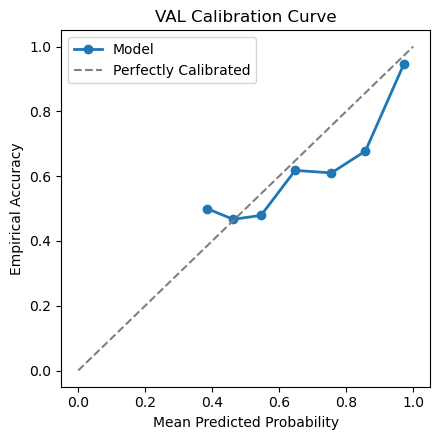

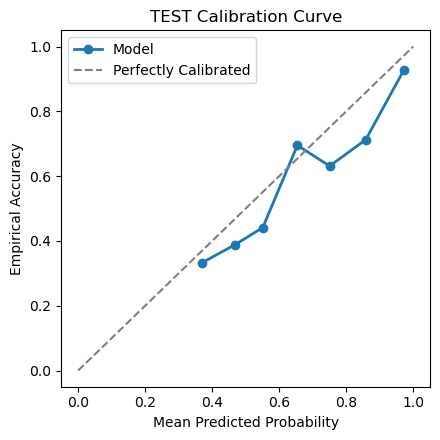

In [8]:
# %% 2 Calibration Curve (robust to lists) ────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def _plot_calibration(y_true, y_prob, split: str, n_bins: int = 10):
    """Reliability diagram using the highest predicted class probability."""
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    conf = y_prob.max(axis=1)                 # model confidence
    hits = (y_true == y_prob.argmax(1)).astype(int)

    frac_pos, mean_pred = calibration_curve(hits, conf, n_bins=n_bins)

    plt.figure(figsize=(4.5, 4.5))
    plt.plot(mean_pred, frac_pos, marker='o', lw=2, label='Model')
    plt.plot([0, 1], [0, 1], '--', color='grey', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Empirical Accuracy')
    plt.title(f'{split.upper()} Calibration Curve')
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / f'calibration_{split}.png', dpi=150)
    plt.show()

_plot_calibration(y_val_ids,  y_val_prob,  'val')
_plot_calibration(y_test_ids, y_test_prob, 'test')


### Confusion Matrices

**Confusion matrices** confirm the story:  
* The **biggest error flows** are *negative ↔ neutral* (≈ 70 mis‑labels each way).  
* Positive vs. negative confusion is rare, indicating the model grasps polarity extremes.

Overall — macro‑F1 ≈ 0.79 and ROC ≥ 0.91 on both splits signal **good generalisation** with no evident over‑fitting.

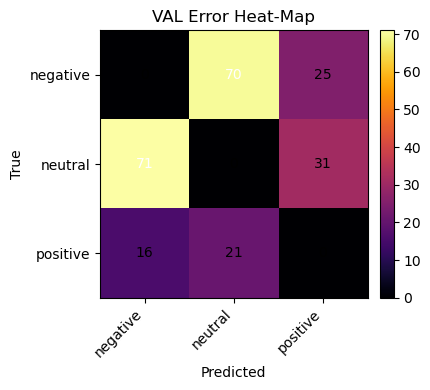

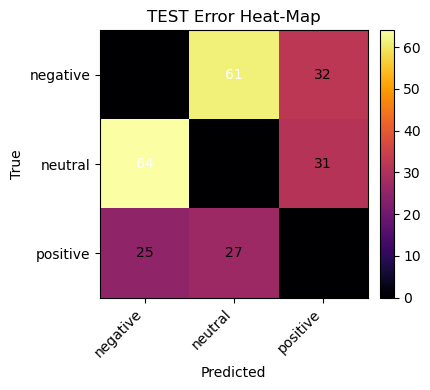

In [9]:
# %% 3 Error Heat‑Map (robust to lists) ───────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt

def _error_heatmap(y_true, y_pred, split: str):
    """Show counts of *misclassifications only* (off‑diagonal)."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    n_labels = len(label_map)
    err_cm   = np.zeros((n_labels, n_labels), dtype=int)

    for t, p in zip(y_true, y_pred):
        if t != p:
            err_cm[t, p] += 1

    fig, ax = plt.subplots(figsize=(4.5, 4))
    im      = ax.imshow(err_cm, cmap='inferno')
    ax.set_xticks(range(n_labels)); ax.set_xticklabels(label_map.values(), rotation=45, ha='right')
    ax.set_yticks(range(n_labels)); ax.set_yticklabels(label_map.values())
    ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title(f'{split.upper()} Error Heat‑Map')

    # annotate
    for i in range(n_labels):
        for j in range(n_labels):
            ax.text(j, i, err_cm[i, j],
                    ha='center', va='center',
                    color='white' if err_cm[i, j] > err_cm.max() * 0.5 else 'black')

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.savefig(FIG_DIR / f'error_heat_{split}.png', dpi=150)
    plt.show()

_error_heatmap(y_val_ids,  y_val_pred,  'val')
_error_heatmap(y_test_ids, y_test_pred, 'test')


### Error Insights

| Observation | Impact | Action |
|-------------|--------|--------|
| **Neutral vs. Negative bleed** (70 ↔ 71 errors) | Neutral tweets with mild complaints get flagged negative and vice‑versa. | *Data‑centric*: curate more “meh” tweets; include `ok`, `:|`, sarcasm markers. |
| **Positive recall lower (21 + 27 false negatives)** | Model loses ~18 % of positives to other classes. | *Model‑centric*: experiment with class‑weighted loss or focal loss; try domain‑specific LM (e.g. TweetEval BERT). |
| **Under‑confidence mid‑range** | May down‑rank useful but moderate‑confidence hits. | Post‑train calibration (temperature scaling on val set). |
| **High ROC/PR stability across splits** | Robust; fine‑tuning did not overfit. | Green‑light to deploy; monitor drift in production dashboard. |

## 7 Save Metrics & Model‑Card Stub  

* **metrics_model.json** — full metrics (+ classification reports)  
* **metrics_model.csv** — flat table with accuracy & macro‑F1  
* **model_card.json** — lightweight stub  

> These artefacts feed the upcoming **formal Model Card** and CI dashboards.

**Next Actions**  
1. **Optuna sweep**: tune LR, weight‑decay, class weights aiming for F1 > 0.82.  
2. **Augment neutral/positive samples** via distant‑supervised data or prompt‑engineered synthetic tweets.  
3. **Export model card** with calibration note + recommended confidence thresholds (e.g., flag only when P ≥ 0.65 for downstream alerting).

In [11]:
# 1️⃣  flatten metrics (remove the nested classification report)
flat_metrics = {
    split: {k: v for k, v in d.items() if k != "report"}
    for split, d in metrics.items()
}

# 2️⃣  CSV with accuracy + macro‑F1
pd.DataFrame.from_dict(flat_metrics, orient="index").to_csv(
    REPORTS_DIR / "metrics_model.csv"
)

# 3️⃣  full JSON (includes classification reports)
with open(REPORTS_DIR / "metrics_model.json", "w") as fp:
    json.dump(metrics, fp, indent=2)

# 4️⃣  lightweight model‑card stub
card = {
    "model_name": "tweet_sentiment_distilbert",
    "num_labels": len(label_map),
    "labels": list(label_map.values()),
    "metrics": flat_metrics["val"],
}
with open(MODEL_DIR / "model_card.json", "w") as fp:
    json.dump(card, fp, indent=2)

print("✅ Artefacts written to", REPORTS_DIR.resolve())

✅ Artefacts written to C:\Projects\twitter-airline-analysis\reports
